# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench import Samplers

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

In [2]:
def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25,
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))

    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt

    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [3]:
# Run the pred_prey function with default parameters
results = pred_prey()

# Output the results to check correctness
print("Time Array:", results['TIME'])
print("Predators Array:", results['predators'])
print("Prey Array:", results['prey'])

Time Array: [[0.0000e+00 2.5000e-01 5.0000e-01 ... 3.6450e+02 3.6475e+02 3.6500e+02]]
Predators Array: [[20.         20.2        20.40136875 ... 37.69187459 37.72581658
  37.75505957]]
Prey Array: [[50.         49.9375     49.87133281 ... 31.8010242  31.55029052
  31.30113215]]


#### 1. Sensitivity analysis
Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment

In [4]:
# Set up logging for EMA workbench (optional but helpful for debugging)
ema_logging.log_to_stderr(ema_logging.INFO)

# Create a Python model
model = Model('PredPreyPython', function=pred_prey)

model.run_length = 365

model.uncertainties = [
    RealParameter('prey_birth_rate', 0.015, 0.035),
    RealParameter('predation_rate', 0.0005, 0.003),
    RealParameter('predator_efficiency', 0.001, 0.004),
    RealParameter('predator_loss_rate', 0.04, 0.08)
]
model.outcomes = [
    TimeSeriesOutcome('TIME'),
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]

# model.outcomes = [TimeSeriesOutcome('predators'),
#                   TimeSeriesOutcome('prey')]

In [6]:
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.samplers import LHSSampler  # Correct import statement for LHSSampler

with SequentialEvaluator(model) as evaluator:
    experiments_python, outcomes_python = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.LHS)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|█████████████████████████████████████| 1000/1000 [00:02<00:00, 366.31it/s]
[MainProcess/INFO] experiments finished


In [8]:
# Extract the data for 'prey' for simplification, assuming it has a shape like (scenarios, 1, time_steps)
prey_data = outcomes_python['prey']
print(prey_data.shape)

(1000, 1, 1461)


In [10]:
# Extract the data for 'prey' for simplification, assuming it has a shape like (scenarios, 1, time_steps)
prey_data = prey_data.squeeze()  # This removes any singleton dimensions, simplifying (1000, 1, 1461) to (1000, 1461)
print(prey_data.shape)
print(prey_data)

(1000, 1461)
[[50.         49.67806345 49.35239731 ... 58.39572959 58.17914335
  57.95582528]
 [50.         49.60939843 49.22416962 ... 42.74640592 42.93238131
  43.11975987]
 [50.         49.85986391 49.71490549 ...  5.22731006  5.22202627
   5.21695855]
 ...
 [50.         49.67171556 49.32783422 ...  0.88378159  0.88434782
   0.8849583 ]
 [50.         49.88231325 49.76050934 ... 25.67584425 25.46501037
  25.25677065]
 [50.         50.06147181 50.11822596 ... 12.50075003 12.38116064
  12.26459219]]


In [11]:
# Now calculate the desired metrics
final_values_prey = prey_data[:, -1]  # Final value at the last timestep
mean_values_prey = np.mean(prey_data, axis=1)  # Mean over all timesteps
std_dev_values_prey = np.std(prey_data, axis=1)  # Standard deviation over all timesteps

# Check shapes to ensure they are now correct (should be (1000,))
print("Shape of final values array:", final_values_prey.shape)
print('Final values', final_values_prey)
print("Shape of mean values array:", mean_values_prey.shape)
print('Mean value per timestep:', mean_values_prey)
print("Shape of standard deviations array:", std_dev_values_prey.shape)
print('Standard deviation per timestep:', std_dev_values_prey)

Shape of final values array: (1000,)
Final values [ 57.95582528  43.11975987   5.21695855  15.31503041  19.97590329
  57.70948664  32.45373028  10.83263772  34.54947146  52.16463728
  38.34220494  48.90067692  46.50831061  26.04520524   8.31356898
   1.26322667  49.16019514  21.06891905  12.89273373  23.30704612
  10.28001517  15.63199791  32.32718354  41.26880687   1.33948198
  11.37987459  16.51273971   0.85655718   2.82354944  54.29373464
   9.8919915    3.00985299  24.92841819  53.88211367  12.62581087
   9.06877258   6.58430297  40.27487851   2.36573531   1.84396298
   3.71410717  15.3291998   19.40337158  10.60326315  14.64638312
  16.85604273  19.78611172  33.99659448  39.59469184  11.40329023
   5.83105756   0.91787558  10.46439395   7.76406016  53.86165268
  17.84240089  58.09044652   4.6568466   16.94172466  14.22805038
  67.36134928  24.03536321  92.33645681  32.17517441  13.21338326
  22.04560011  20.91791931   2.25679024  20.18144976  44.48776739
  24.46428936  11.18206015

In [7]:
import statsmodels.api as sm

# Prepare the predictors, adding a constant for the intercept
X = sm.add_constant(experiments_python[['prey_birth_rate', 'predation_rate', 'predator_efficiency', 'predator_loss_rate']])

# Fit the regression models
model_final_values = sm.OLS(final_values_prey, X).fit()
model_mean_values = sm.OLS(mean_values_prey, X).fit()
model_std_dev_values = sm.OLS(std_dev_values_prey, X).fit()

# Print the regression summaries to understand the impact of parameters
print("Regression Model for Final Values of Prey:")
print(model_final_values.summary())

Regression Model for Final Values of Prey:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     182.1
Date:                Mon, 20 May 2024   Prob (F-statistic):          4.38e-117
Time:                        15:25:30   Log-Likelihood:                -4173.9
No. Observations:                1000   AIC:                             8358.
Df Residuals:                     995   BIC:                             8382.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [8]:
print("\nRegression Model for Mean Values of Prey:")
print(model_mean_values.summary())


Regression Model for Mean Values of Prey:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1650.
Date:                Mon, 20 May 2024   Prob (F-statistic):               0.00
Time:                        15:25:30   Log-Likelihood:                -2959.5
No. Observations:                1000   AIC:                             5929.
Df Residuals:                     995   BIC:                             5953.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [9]:
print("\nRegression Model for Standard Deviations of Prey:")
print(model_std_dev_values.summary())


Regression Model for Standard Deviations of Prey:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     28.41
Date:                Mon, 20 May 2024   Prob (F-statistic):           2.24e-22
Time:                        15:25:30   Log-Likelihood:                -2626.3
No. Observations:                1000   AIC:                             5263.
Df Residuals:                     995   BIC:                             5287.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

#### 2. SOBOL
Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function.

*hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply use slicing to get the results for N=50 and N=250.

In [18]:
problem = get_SALib_problem(model.uncertainties)

print(problem)

{'num_vars': 4, 'names': ['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate'], 'bounds': [(0.0005, 0.003), (0.001, 0.004), (0.04, 0.08), (0.015, 0.035)]}


# How Kwakkel Did it

In [19]:
n_exp = 1000

experiments_sobol, outcomes_sobol = perform_experiments(model, scenarios=n_exp, uncertainty_sampling=Samplers.SOBOL)

prey_final_sobol = outcomes_sobol['prey'][:,0,-1]
prey_mean_sobol = np.mean(outcomes_sobol['prey'][:,0,:],axis=1)
prey_std_sobol = np.std(outcomes_sobol['prey'][:,0,:],axis=1)

Si = sobol.analyze(problem, prey_mean_sobol, calc_second_order=True, print_to_console=True)

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|███████████████████████████████████| 10000/10000 [00:27<00:00, 367.59it/s]
[MainProcess/INFO] experiments finished
C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                           ST   ST_conf
predation_rate       0.005077  0.000792
predator_efficiency  0.821868  0.061498
predator_loss_rate   0.218682  0.023692
prey_birth_rate      0.011281  0.001312
                           S1   S1_conf
predation_rate       0.003535  0.007137
predator_efficiency  0.788959  0.068282
predator_loss_rate   0.182619  0.035983
prey_birth_rate      0.005634  0.009649
                                                 S2   S2_conf
(predation_rate, predator_efficiency)      0.000068  0.014026
(predation_rate, predator_loss_rate)       0.002014  0.010827
(predation_rate, prey_birth_rate)          0.002082  0.010639
(predator_efficiency, predator_loss_rate)  0.013140  0.123703
(predator_efficiency, prey_birth_rate)    -0.014415  0.103594
(predator_loss_rate, prey_birth_rate)      0.004400  0.054170


In [24]:
import pandas as pd
import seaborn as sns

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
print(Si_filter)

{'ST': array([0.00507707, 0.82186845, 0.21868227, 0.01128107]), 'ST_conf': array([0.00079235, 0.06149808, 0.02369238, 0.00131158]), 'S1': array([0.00353522, 0.788959  , 0.18261899, 0.00563383]), 'S1_conf': array([0.00713676, 0.06828214, 0.03598332, 0.00964908])}


In [26]:
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
print(Si_df)

                           ST   ST_conf        S1   S1_conf
predation_rate       0.005077  0.000792  0.003535  0.007137
predator_efficiency  0.821868  0.061498  0.788959  0.068282
predator_loss_rate   0.218682  0.023692  0.182619  0.035983
prey_birth_rate      0.011281  0.001312  0.005634  0.009649


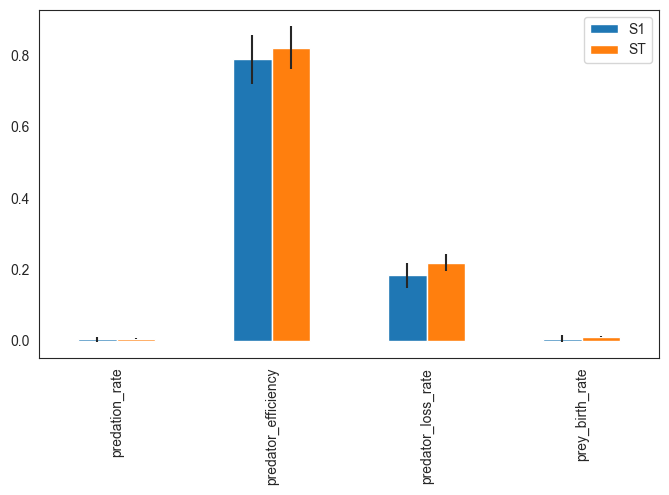

In [27]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
Y = prey_mean_sobol

sobol_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_exp,50)*(2*problem['num_vars']+2))
for j in sobol_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    sobol_data.loc[:,j] = scores['ST']

In [ ]:
fig, ax = plt.subplots(1)

sobol_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
plt.show()

# How I Did It

In [10]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

# Function to run Sobol experiments
def run_sobol_experiments(N):
    D = len(model.uncertainties)
    scenarios = N * (2 * D + 2)
    
    with SequentialEvaluator(model) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(scenarios=scenarios, uncertainty_sampling=Samplers.SOBOL)
    
    return experiments, outcomes

# Run experiments for N=1000
experiments_1000, outcomes_1000 = run_sobol_experiments(1000)

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 100000 scenarios * 1 policies * 1 model(s) = 100000 experiments
100%|█████████████████████████████████| 100000/100000 [04:46<00:00, 348.79it/s]
[MainProcess/INFO] experiments finished


In [11]:
# Slice for N=50 and N=250
def slice_experiments_outcomes(experiments, outcomes, N):
    slice_size = N * (2 * len(model.uncertainties) + 2)
    experiments_sliced = experiments[:slice_size]
    outcomes_sliced = {key: value[:slice_size] for key, value in outcomes.items()}
    return experiments_sliced, outcomes_sliced

experiments_50, outcomes_50 = slice_experiments_outcomes(experiments_1000, outcomes_1000, 50)
experiments_250, outcomes_250 = slice_experiments_outcomes(experiments_1000, outcomes_1000, 250)

In [18]:
# Define the problem
problem = get_SALib_problem(model.uncertainties)

def sobol_analysis(outcomes, problem, metric):
    Y = outcomes[metric].squeeze()
    final_values = Y[:, -1]
    mean_values = np.mean(Y, axis=1)
    std_dev_values = np.std(Y, axis=1)
    
    # Perform Sobol analysis
    Si_final = sobol.analyze(problem, final_values, calc_second_order=True, print_to_console=False)
    Si_mean = sobol.analyze(problem, mean_values, calc_second_order=True, print_to_console=False)
    Si_std_dev = sobol.analyze(problem, std_dev_values, calc_second_order=True, print_to_console=False)
    
    return Si_final, Si_mean, Si_std_dev

In [19]:
# Analyze for N=50
Si_final_50, Si_mean_50, Si_std_dev_50 = sobol_analysis(outcomes_50, problem, 'prey')

print("Sobol Analysis for Final Values (N=50):")
print(Si_final_50)

print("Sobol Analysis for Mean Values (N=50):")
print(Si_mean_50)

print("Sobol Analysis for Standard Deviations (N=50):")
print(Si_std_dev_50)

Sobol Analysis for Final Values (N=50):
{'S1': array([0.05220518, 0.56035257, 0.02188268, 0.00655341]), 'S1_conf': array([0.12709617, 0.39661697, 0.18306741, 0.25653695]), 'ST': array([0.14614875, 0.95647045, 0.38603494, 0.44595818]), 'ST_conf': array([0.09689093, 0.26924982, 0.19836593, 0.24907419]), 'S2': array([[        nan, -0.1201632 , -0.03041184, -0.04988314],
       [        nan,         nan, -0.13030598, -0.2651851 ],
       [        nan,         nan,         nan,  0.23579459],
       [        nan,         nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.17313335, 0.18605707, 0.17297322],
       [       nan,        nan, 0.35776004, 0.41417717],
       [       nan,        nan,        nan, 0.3050637 ],
       [       nan,        nan,        nan,        nan]])}
Sobol Analysis for Mean Values (N=50):
{'S1': array([-0.00638818,  0.93998318,  0.13446003, -0.00465011]), 'S1_conf': array([0.02192071, 0.40160394, 0.18549571, 0.05210269]), 'ST': array([0.00546641, 0.98

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [20]:
# Analyze for N=250
Si_final_250, Si_mean_250, Si_std_dev_250 = sobol_analysis(outcomes_250, problem, 'prey')

print("Sobol Analysis for Final Values (N=250):")
print(Si_final_250)

print("Sobol Analysis for Mean Values (N=250):")
print(Si_mean_250)

print("Sobol Analysis for Standard Deviations (N=250):")
print(Si_std_dev_250)

Sobol Analysis for Final Values (N=250):
{'S1': array([-0.00670834,  0.37945839,  0.09436046, -0.05839143]), 'S1_conf': array([0.04880689, 0.15973888, 0.13823322, 0.13021505]), 'ST': array([0.1184057 , 0.87372632, 0.58398332, 0.59127296]), 'ST_conf': array([0.04457543, 0.14126763, 0.12118959, 0.13152509]), 'S2': array([[        nan,  0.00602749, -0.00275181, -0.01990888],
       [        nan,         nan,  0.07402459,  0.09353167],
       [        nan,         nan,         nan,  0.13659631],
       [        nan,         nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.07883205, 0.06781806, 0.06664825],
       [       nan,        nan, 0.19443899, 0.24346169],
       [       nan,        nan,        nan, 0.21439527],
       [       nan,        nan,        nan,        nan]])}
Sobol Analysis for Mean Values (N=250):
{'S1': array([0.00497281, 0.78131609, 0.18147821, 0.00874752]), 'S1_conf': array([0.01236705, 0.16185225, 0.07990147, 0.01808464]), 'ST': array([0.005885  , 0.

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [29]:
# Analyze for N=1000
Si_final_1000, Si_mean_1000, Si_std_dev_1000 = sobol_analysis(outcomes_1000, problem, 'prey')

print("Sobol Analysis for Final Values (N=1000):")
print(Si_final_1000)

print("Sobol Analysis for Mean Values (N=1000):")
print(Si_mean_1000)

print("Sobol Analysis for Standard Deviations (N=1000):")
print(Si_std_dev_1000)

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Sobol Analysis for Final Values (N=1000):
{'S1': array([0.00040551, 0.36561104, 0.06781177, 0.01817731]), 'S1_conf': array([0.01056799, 0.02410411, 0.01956881, 0.02154838]), 'ST': array([0.13325698, 0.81891056, 0.61520979, 0.54244437]), 'ST_conf': array([0.00851212, 0.02500168, 0.02211154, 0.01783769]), 'S2': array([[        nan,  0.00914185,  0.00570301, -0.00300418],
       [        nan,         nan,  0.01481345,  0.00139853],
       [        nan,         nan,         nan,  0.06564466],
       [        nan,         nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.01753344, 0.01527092, 0.01423849],
       [       nan,        nan, 0.03202529, 0.03669952],
       [       nan,        nan,        nan, 0.02947426],
       [       nan,        nan,        nan,        nan]])}
Sobol Analysis for Mean Values (N=1000):
{'S1': array([0.00275554, 0.7740632 , 0.17894101, 0.00189723]), 'S1_conf': array([0.00196838, 0.02764567, 0.01151922, 0.00258503]), 'ST': array([0.00507536, 0.81

# Conclusion Based on Last Output Cell
- Predation Rate is the most influential parameter, both independently and through interactions, affecting the final prey population.
- Predator Efficiency and Predator Loss Rate also have significant effects, mainly through interactions.
- Prey Birth Rate has a minimal independent effect but contributes through interactions.
- The interaction between Predator Efficiency and Predator Loss Rate is the most notable second-order effect.

#### 3. Extra trees
Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)